# **0. Import Library**

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.fftpack
import seaborn as sns
import cloudpickle as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from scipy.io import wavfile
from cvxopt import matrix, solvers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# **1. Data Preprocessing**

### **1.1. Set Important Variables**

In [2]:
base_path = './sounds/'
categories = ['ambulance', 'firetruck', 'traffic']
data_path = []
labels = []

### **1.2. Load Dataset**

In [3]:
for category in categories:
    folder_path = f'sounds/{category}'
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            data_path.append(file_path)
            labels.append(category)

In [4]:
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {set(labels)}")
label_counts = Counter(labels)
print(f"Number of each label: {dict(label_counts)}")

Number of labels: 600
Unique labels: {'traffic', 'firetruck', 'ambulance'}
Number of each label: {'ambulance': 200, 'firetruck': 200, 'traffic': 200}


### **1.3. Data Augmentation**

In [5]:
def add_noise(signal, noise_level=0.005):
    noise = np.random.randn(len(signal))
    augmented = signal + noise_level * noise
    return augmented.astype(np.float32)

def time_stretch(signal, stretch_factor=1.1):
    indices = np.arange(0, len(signal), stretch_factor)
    indices = indices[indices < len(signal)].astype(int)
    return signal[indices]

def pitch_shift(signal, sr, n_steps=2):
    factor = 2 ** (n_steps / 12)
    resampled = scipy.signal.resample(signal, int(len(signal) / factor))
    if len(resampled) < len(signal):
        pad_width = len(signal) - len(resampled)
        resampled = np.pad(resampled, (0, pad_width), mode='constant')
    else:
        resampled = resampled[:len(signal)]
    return resampled.astype(np.float32)

def volume_perturb(signal, gain=1.2):
    return (signal * gain).astype(np.float32)

def fix_len(sig, target_len):
    if len(sig) < target_len:
        return np.pad(sig, (0, target_len - len(sig)), mode='constant')
    else:
        return sig[:target_len]

In [6]:
def augment_audio(signal, sr):
    aug1 = signal
    aug2 = add_noise(signal)
    aug3 = time_stretch(signal, 1.1)
    aug4 = pitch_shift(signal, sr, n_steps=2)
    aug5 = volume_perturb(signal, gain=0.8)

    original_len = len(signal)
    all_signals = [fix_len(s, original_len) for s in [aug1, aug2, aug3, aug4, aug5]]
    return all_signals

In [7]:
def load_audio(filepath):
    sr, data = wavfile.read(filepath)
    if len(data.shape) > 1:
        data = data[:, 0]
    data = data.astype(np.float32)
    return sr, data

In [8]:
def augment_signal(filepath):
    sr, signal = load_audio(filepath)
    augmented_signals = augment_audio(signal, sr)
    sr_signal_pair = []
    for aug_signal in augmented_signals:
        sr_signal_pair.append((sr, aug_signal))
    return sr_signal_pair

In [9]:
augmented_data = []
for file_path in tqdm(data_path, desc="Augmenting audio files"):
    augmented_data.extend(augment_signal(file_path))
print(f"Total augmented samples: {len(augmented_data)}")

augmented_df = pd.DataFrame(augmented_data, columns=['sample_rate', 'signal'])
augmented_df['label'] = np.repeat(labels, 5)
print(augmented_df)

Augmenting audio files: 100%|██████████| 600/600 [00:11<00:00, 54.29it/s]

Total augmented samples: 3000
      sample_rate                                             signal  \
0           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1           44100  [0.0042600557, -0.0020886527, -0.0062843617, -...   
2           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3           44100  [14.3213005, -4.9273396, 2.7958882, -1.9206804...   
4           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...           ...                                                ...   
2995        44100  [-1113.0, -858.0, -563.0, -230.0, 98.0, 357.0,...   
2996        44100  [-1112.9961, -858.0041, -562.9968, -229.99547,...   
2997        44100  [-1113.0, -858.0, -563.0, -230.0, 98.0, 357.0,...   
2998        44100  [-1075.7485, -837.7126, -476.45578, -110.32513...   
2999        44100  [-890.4, -686.4, -450.4, -184.0, 78.4, 285.6, ...   

          label  
0     ambulance  
1     ambulance  
2     ambulance  
3     ambulance  
4     ambulance

# **2. Feature Extraction**

### **2.1. Time Domain**

In [10]:
def time_domain_features(signal):
    zcr = np.mean(np.abs(np.diff(np.sign(signal)))) / 2
    rms = np.sqrt(np.mean(signal**2))
    return zcr, rms

### **2.2. Domain Frekuensi**

In [11]:
def frequency_domain_features(signal, sr):
    N = len(signal)
    fft = np.fft.rfft(signal)
    mag = np.abs(fft)
    freqs = np.fft.rfftfreq(N, d=1/sr)

    spec_centroid = np.sum(freqs * mag) / np.sum(mag)
    spec_bandwidth = np.sqrt(np.sum(((freqs - spec_centroid)**2) * mag) / np.sum(mag))
    rolloff_thresh = 0.85 * np.sum(mag)
    rolloff_freq = freqs[np.where(np.cumsum(mag) >= rolloff_thresh)[0][0]]

    return spec_centroid, spec_bandwidth, rolloff_freq

### **2.3. MFCC Feature**

In [12]:
def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700.0)
def mel_to_hz(mel): return 700 * (10**(mel / 2595.0) - 1)

def mfcc(signal, sr, n_mfcc=13, n_filters=26, n_fft=512):
    # 1. Framing
    frame_len = int(0.025 * sr)
    frame_step = int(0.010 * sr)
    signal_len = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_len - frame_len)) / frame_step)) + 1

    pad_len = num_frames * frame_step + frame_len
    z = np.zeros((pad_len - signal_len))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_len), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_len, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # 2. Windowing
    frames *= np.hamming(frame_len)

    # 3. FFT and power spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, n_fft))
    pow_frames = ((1.0 / n_fft) * (mag_frames ** 2))

    # 4. Mel filterbank
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sr / 2)
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    fbank = np.zeros((n_filters, int(n_fft / 2 + 1)))
    for m in range(1, n_filters + 1):
        f_m_minus, f_m, f_m_plus = bin[m - 1], bin[m], bin[m + 1]
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbanks = np.log(filter_banks)

    # 5. DCT
    mfccs = scipy.fftpack.dct(log_fbanks, type=2, axis=1, norm='ortho')[:, :n_mfcc]
    return np.mean(mfccs, axis=0)


### **2.4. Extract Features From Data**

In [13]:
def extract_all_features(sr, signal):
    zcr, rms = time_domain_features(signal)
    centroid, bandwidth, rolloff = frequency_domain_features(signal, sr)
    mfccs = mfcc(signal, sr)
    return np.array([zcr, rms, centroid, bandwidth, rolloff] + mfccs.tolist())

In [14]:
extracted_data = []
for data in tqdm(augmented_data, desc="Extracting features"):
    sr, signal = data[0], data[1]
    features = extract_all_features(sr, signal)
    extracted_data.append(features)

Extracting features: 100%|██████████| 3000/3000 [00:43<00:00, 68.72it/s]


In [15]:
data_uniform = []
for feature_list in extracted_data:
    processed_features = []
    for feature in feature_list:
        if isinstance(feature, np.ndarray):
            processed_features.append(feature.item())
        else:
            processed_features.append(feature)
    data_uniform.append(processed_features)

X = np.array(data_uniform)
y = np.array(np.repeat(labels, 5))

print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of label vector y: {y.shape}")

Shape of feature matrix X: (3000, 18)
Shape of label vector y: (3000,)


# **3. Set Up and Train Model**

### **3.1. Support Vector Machine (SVM) Model**

In [16]:
class SVM:
    
    # Fungsi konstruktor untuk menginisialisasi parameter SVM
    def __init__(self, kernel='rbf', C=10.0, degree=3, gamma=0.1):
        self.kernel_type = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.models = {}
        self.is_multiclass = False
    
    # Fungsi untuk mendapatkan parameter SVM
    def get_params(self):
        return {
            "C": self.C,
            "kernel": self._compute_kernel,
            "gamma": self.gamma,
            "degree": self.degree,
        }

    # Fungsi untuk mengatur parameter SVM
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Fungsi untuk menghitung kernel
    def _compute_kernel(self, x, y):
        if self.kernel_type == 'linear':
            return np.dot(x, y)
        elif self.kernel_type == 'poly':
            return (1 + self.gamma * np.dot(x, y)) ** self.degree
        elif self.kernel_type == 'rbf':
            return np.exp(-self._gamma * np.linalg.norm(x - y) ** 2)
        else:
            raise ValueError("Unknown kernel")

    # Fungsi untuk melakukan proses fitting model SVM
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        self.is_multiclass = n_classes > 2

        if self.is_multiclass:
            self.models = {}
            print(f"Training {n_classes} OvR SVM models...\n")
            for cls in tqdm(self.classes, desc="OvR SVM Training"):
                y_binary = np.where(y == cls, 1, -1)
                model = SVM(kernel=self.kernel_type, C=self.C, degree=self.degree, gamma=self.gamma)
                model.fit(X, y_binary)
                self.models[cls] = model
        else:
            y = y.astype(float)
            n_samples, n_features = X.shape
            self.X = X
            self.y = y

            if self.kernel_type == 'rbf':
                self._gamma = self.gamma if self.gamma else 1 / n_features

            # Gram matrix
            K = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(n_samples):
                    K[i, j] = self._compute_kernel(X[i], X[j])

            P = matrix(np.outer(y, y) * K)
            q = matrix(-np.ones(n_samples))
            A = matrix(y.reshape(1, -1))
            b = matrix(0.0)

            if self.C is None:
                G = matrix(-np.eye(n_samples))
                h = matrix(np.zeros(n_samples))
            else:
                G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
                h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

            solvers.options['show_progress'] = False
            solution = solvers.qp(P, q, G, h, A, b)
            alphas = np.ravel(solution['x'])

            # Support vectors
            sv = alphas > 1e-5
            self.alphas = alphas[sv]
            self.support_vectors = X[sv]
            self.support_vector_labels = y[sv]
            # print(f"Self Alphas: {self.alphas}")
            # print(f"Alphas shape: {self.alphas.shape}")
            # print(f"Support vectors shape: {self.support_vectors.shape}")

            # Intercept
            self.b = np.mean([
                y_k - np.sum(self.alphas * self.support_vector_labels *
                             [self._compute_kernel(x_k, x_i) for x_i in self.support_vectors])
                for (x_k, y_k) in zip(self.support_vectors, self.support_vector_labels)
            ])

    # Fungsi untuk menghitung nilai keputusan
    def project(self, X):
        if self.is_multiclass:
            decision_values = np.column_stack([
                model.project(X) for model in self.models.values()
            ])
            return decision_values
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for alpha, sv_y, sv in zip(self.alphas, self.support_vector_labels, self.support_vectors):
                    s += alpha * sv_y * self._compute_kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    
    # Fungsi untuk menghitung probabilitas prediksi
    def predict_proba(self, X):
        if not self.is_multiclass:
            raise NotImplementedError("predict_proba hanya didukung untuk mode multiclass OvR")

        decision = self.project(X)
        # Softmax untuk setiap baris
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))  # stabilisasi
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    # Fungsi untuk melakukan prediksi
    def predict(self, X):
        if self.is_multiclass:
            decision = self.project(X)
            predictions = np.argmax(decision, axis=1)
            return self.classes[predictions]
        else:
            return np.sign(self.project(X))

### **3.2. Train Test Split**

In [17]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Check class distribution in train and test sets
train_distribution = {category: np.sum(y_train_raw == category) for category in categories}
test_distribution = {category: np.sum(y_test_raw == category) for category in categories}

print("\nClass distribution in training set:")
for category, count in train_distribution.items():
    print(f"  {category}: {count}")

print("\nClass distribution in testing set:")
for category, count in test_distribution.items():
    print(f"  {category}: {count}")

X_train shape: (2400, 18)
X_test shape: (600, 18)
y_train shape: (2400,)
y_test shape: (600,)

Class distribution in training set:
  ambulance: 800
  firetruck: 800
  traffic: 800

Class distribution in testing set:
  ambulance: 200
  firetruck: 200
  traffic: 200


### **3.3. Train Model**

In [18]:
model = SVM()
model.fit(X_train, y_train)

Training 3 OvR SVM models...



OvR SVM Training: 100%|██████████| 3/3 [04:47<00:00, 95.97s/it] 


# **4. Evaluate Model**

### **4.1. Labels Prediction**

In [19]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 99.83%


### **4.2. Metrics Evaluation**

Classification Report:
              precision    recall  f1-score   support

   ambulance       1.00      0.99      1.00       200
   firetruck       1.00      1.00      1.00       200
     traffic       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



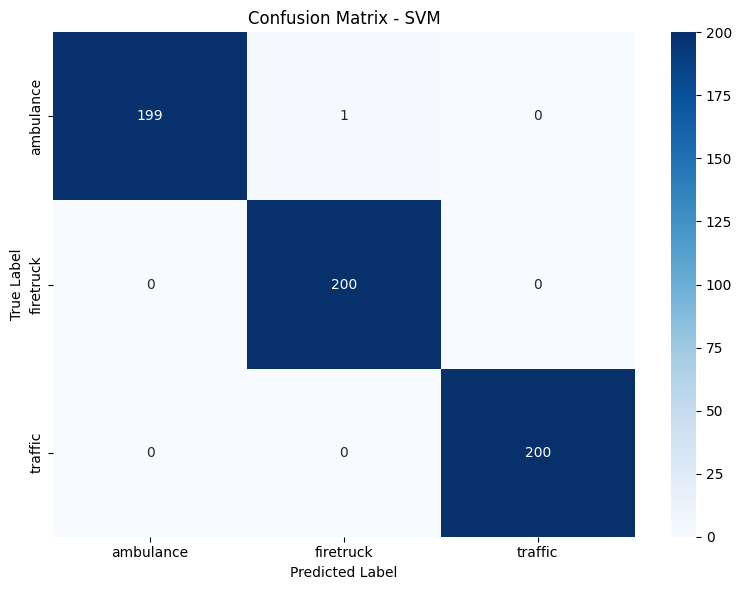

In [20]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# **5. Export Model**

In [21]:
with open("svm_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [22]:
with open("svm_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [23]:
with open("svm_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)